In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from PIL import Image

from tqdm import tqdm
from collections import defaultdict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        # features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return image, label

In [4]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        # features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
        
        if self.transform:
            image = self.transform(image)
                        
        return image, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        # features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return image, features

In [6]:
img_dir = "./AML_project/data/train_set/train_set"
labels = "./AML_project/data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
transform = transforms.Compose(
                    [transforms.RandomApply(
                        [transforms.ColorJitter(),
                         transforms.CenterCrop(100),
                         transforms.Grayscale(3),
                         transforms.RandomAffine(180)]),
                     transforms.RandomHorizontalFlip(),
                     transforms.Resize((256, 256)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225]),
])

transforms2 = transforms.Compose([transforms.Resize((256, 256)),  
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                       std=[0.229, 0.224, 0.225])])

# feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

# Create datasets
train_set = food_train(labels, img_dir, transform = transforms2)
trainloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, transform=transforms2)
valloader = DataLoader(val_set, batch_size=8, shuffle=True, num_workers=0)

len(train_set), len(val_set)

(25000, 5611)

In [7]:
test_set = food_test("./AML_project/data/test_set/test_set")
testloader = DataLoader(test_set, batch_size = 8)

len(test_set)

7653

In [8]:
# Load EfficientNet
efficientnet_b7 = models.efficientnet_b7(pretrained=True)

efficientnet_b7.classifier = torch.nn.Linear(2560, 81)

In [9]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet_b7.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(beit.parameters(), lr=0.00001)

In [10]:
len(trainloader.dataset)

25000

In [11]:
def train_loop(dataloader, model, criterion, optimizer):
    # Get size of dataset
    size = len(dataloader.dataset)
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    stats["epoch"].append(0)
    stats["loss"].append(8.7)
    stats["accuracy"].append(1.25)
    
    for epoch in range(10):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)            
            pred = model(image)
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")
        
        # Print performance after current number of epochs
        print(f"Epoch: {epoch + 1}")
        current_acc, avg_loss = test_loop(valloader, model, criterion)
        
        if current_acc > max_acc:
            PATH = f'./efficientnet.pth'
            torch.save(model.state_dict(), PATH)
            max_acc = current_acc
            
        # Store metadata
        stats["epoch"].append(epoch + 1)
        stats["accuracy"].append(current_acc)
        stats["loss"].append(avg_loss)
        
        # Plot progress
        fig, ax1 = plt.subplots()

        color = "tab:blue"
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color=color)
        ax1.plot(stats["epoch"], stats["loss"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)

        ax2 = ax1.twinx()

        color = "tab:orange"
        ax2.set_ylabel("Accuracy", color=color)
        ax2.plot(stats["epoch"], stats["accuracy"], color=color)
        ax2.tick_params(axis="y", labelcolor=color)
        plt.show()
    
    return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

loss: 4.391179  [    0/25000] epoch: 1
loss: 4.317392  [ 1600/25000] epoch: 1
loss: 4.269304  [ 3200/25000] epoch: 1
loss: 3.977617  [ 4800/25000] epoch: 1
loss: 3.995663  [ 6400/25000] epoch: 1
loss: 3.613289  [ 8000/25000] epoch: 1
loss: 3.540555  [ 9600/25000] epoch: 1
loss: 3.264719  [11200/25000] epoch: 1
loss: 3.271892  [12800/25000] epoch: 1
loss: 2.822900  [14400/25000] epoch: 1
loss: 3.103910  [16000/25000] epoch: 1
loss: 2.623103  [17600/25000] epoch: 1
loss: 2.633342  [19200/25000] epoch: 1
loss: 2.968476  [20800/25000] epoch: 1
loss: 2.377888  [22400/25000] epoch: 1
loss: 1.729402  [24000/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 43.3%, Avg loss: 2.317587 



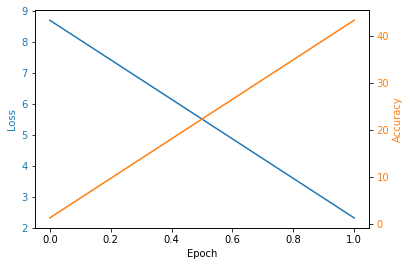

loss: 2.895295  [    0/25000] epoch: 2
loss: 2.272258  [ 1600/25000] epoch: 2
loss: 1.756678  [ 3200/25000] epoch: 2
loss: 1.535158  [ 4800/25000] epoch: 2
loss: 2.291977  [ 6400/25000] epoch: 2
loss: 2.135739  [ 8000/25000] epoch: 2
loss: 1.916960  [ 9600/25000] epoch: 2
loss: 2.171117  [11200/25000] epoch: 2
loss: 1.866580  [12800/25000] epoch: 2
loss: 2.829257  [14400/25000] epoch: 2
loss: 1.126032  [16000/25000] epoch: 2
loss: 1.643009  [17600/25000] epoch: 2
loss: 1.327833  [19200/25000] epoch: 2
loss: 1.598902  [20800/25000] epoch: 2
loss: 1.459901  [22400/25000] epoch: 2
loss: 1.634907  [24000/25000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.847890 



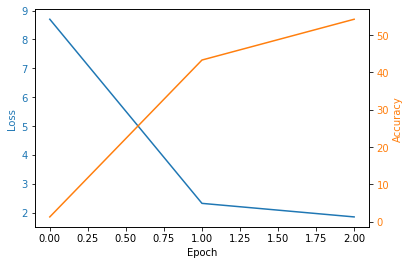

loss: 1.854535  [    0/25000] epoch: 3
loss: 1.188911  [ 1600/25000] epoch: 3
loss: 0.869012  [ 3200/25000] epoch: 3
loss: 1.722964  [ 4800/25000] epoch: 3
loss: 2.399200  [ 6400/25000] epoch: 3
loss: 1.559843  [ 8000/25000] epoch: 3
loss: 0.682422  [ 9600/25000] epoch: 3
loss: 1.768100  [11200/25000] epoch: 3
loss: 2.293805  [12800/25000] epoch: 3
loss: 1.867602  [14400/25000] epoch: 3
loss: 1.090529  [16000/25000] epoch: 3
loss: 0.973012  [17600/25000] epoch: 3
loss: 2.242350  [19200/25000] epoch: 3
loss: 2.861832  [20800/25000] epoch: 3
loss: 2.232188  [22400/25000] epoch: 3
loss: 1.979298  [24000/25000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.708135 



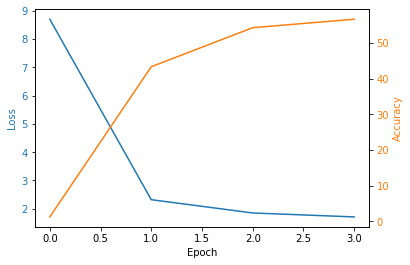

loss: 2.013112  [    0/25000] epoch: 4
loss: 0.977839  [ 1600/25000] epoch: 4
loss: 0.263688  [ 3200/25000] epoch: 4
loss: 1.556876  [ 4800/25000] epoch: 4
loss: 0.960839  [ 6400/25000] epoch: 4
loss: 1.459919  [ 8000/25000] epoch: 4
loss: 1.112523  [ 9600/25000] epoch: 4
loss: 1.080565  [11200/25000] epoch: 4
loss: 1.768489  [12800/25000] epoch: 4
loss: 1.202912  [14400/25000] epoch: 4
loss: 0.809135  [16000/25000] epoch: 4
loss: 0.440473  [17600/25000] epoch: 4
loss: 1.177334  [19200/25000] epoch: 4
loss: 1.125176  [20800/25000] epoch: 4
loss: 1.097492  [22400/25000] epoch: 4
loss: 1.377804  [24000/25000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 58.2%, Avg loss: 1.630131 



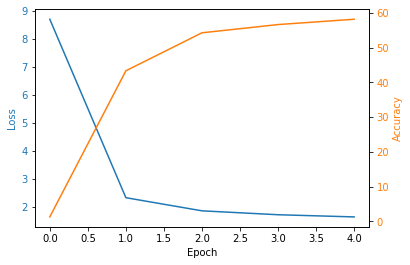

loss: 1.049471  [    0/25000] epoch: 5
loss: 0.497281  [ 1600/25000] epoch: 5
loss: 0.600527  [ 3200/25000] epoch: 5
loss: 0.706183  [ 4800/25000] epoch: 5
loss: 0.807830  [ 6400/25000] epoch: 5
loss: 0.699030  [ 8000/25000] epoch: 5
loss: 1.161725  [ 9600/25000] epoch: 5
loss: 1.654281  [11200/25000] epoch: 5
loss: 0.790166  [12800/25000] epoch: 5
loss: 1.043808  [14400/25000] epoch: 5
loss: 1.422692  [16000/25000] epoch: 5
loss: 1.127316  [17600/25000] epoch: 5
loss: 0.888712  [19200/25000] epoch: 5
loss: 0.650227  [20800/25000] epoch: 5
loss: 0.802706  [22400/25000] epoch: 5
loss: 1.196467  [24000/25000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.649967 



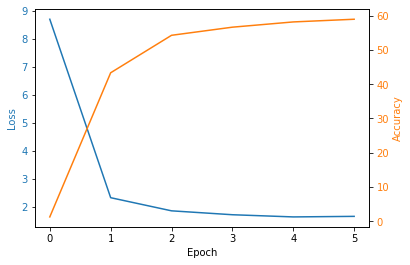

loss: 0.570040  [    0/25000] epoch: 6


KeyboardInterrupt: 

In [12]:
stats = train_loop(trainloader, efficientnet_b7, criterion, optimizer)